In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

%matplotlib inline

Constants

In [2]:
# 1D EDO for Fold bifurcation paramaters
a1 = -1
a2 = 1

# 2D EDO for Hopf bifurcation parameters
b1 = b2 = 1
c1 = -1
c2 = 1

# coupling parameters
gamma1 = -0.1
gamma2 = 0.12

TRESHOLD = 10**-4

ODEs

In [3]:
import numpy as np

# linear coupling parameter
# proposed by Dekker et al. article
def gamma(x):
  return gamma1 + (gamma2 * x)

"""
  :x: float
"""
def fold(x, phi):
  return (a1 * (x ** 3)) + (a2 * x) + phi

def fold_df(x, phi):
  return (3 * a1 * (x ** 2)) + a2

"""
  :r: float
"""
def hopf_polar(r, gam):
  return (gam * r) - (r ** 3)

def hopf_polar_df(r, gam):
  return gam - (3 * (r ** 2))

"""
  :r: float
"""
def hopf_polar_coupled(r, x):
  return (gamma(x) * r) - (r ** 3)

def hopf_polar_coupled_df(r, x):
  return gamma(x) - (3 * (r ** 2))


# v is a vector \vec{v}: [x, y, z]
def fold_hopf(v, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    b1*v[2] + b2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1*v[1] + c2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

l = [[1, 2], [3, 4]]
l
list(zip(*sorted(l, key=lambda x: x[0])))

[(1, 3), (2, 4)]

Bifurcations

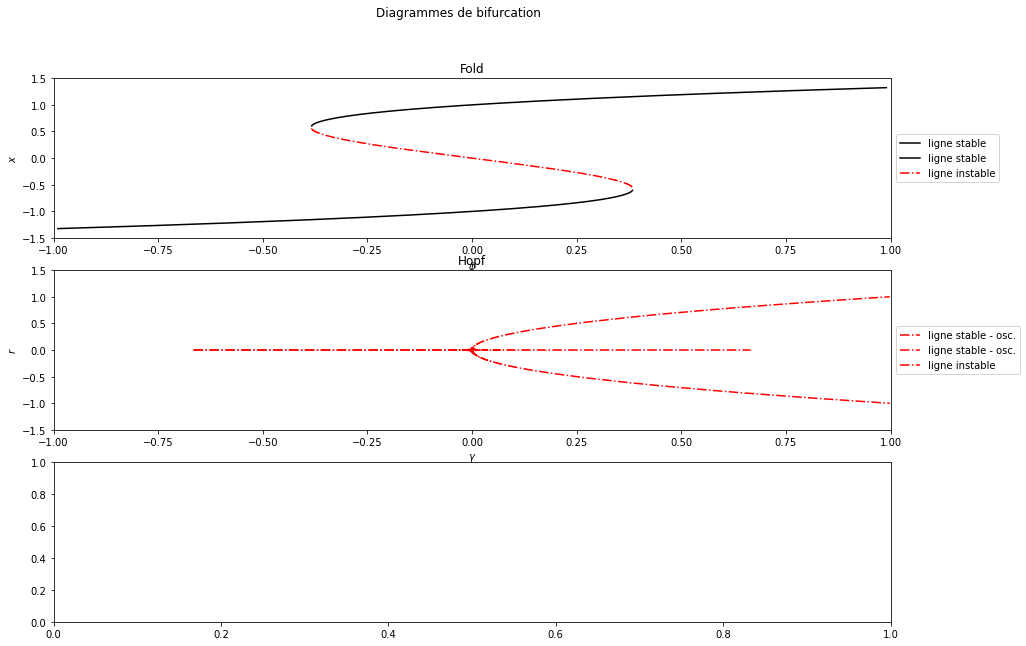

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle("Diagrammes de bifurcation")

"""Leading vs forcing \phi

"""
def fold_bifurcation(fx, df):
  stable_equ_up = []
  stable_equ_down = []
  unstable_equ = []
  
  nphi = 1000
  nx = 10000
  
  phi_mesh = np.linspace(start=-1, stop=1, num=nphi)
  x_mesh = np.linspace(start=-1.5, stop=1.5, num=nx)
  
  # algorithm
  for phi in phi_mesh:
    for x in x_mesh:
      f_value = fx(x, phi)
      #print(f_value)
      # check if I am in trusting interval (i.e. near an equilibirum point such that \dot{r} = 0)
      if - TRESHOLD < f_value < TRESHOLD:
        # YEAH ! We hit an equilibrium point. 
        # Check its stability (stable or unstable)
        df_value = df(x, phi)
        if df_value > 0:
          unstable_equ.append([phi, x])
        elif df_value < 0:
          if x > 0.:  
            stable_equ_up.append([phi, x])
          elif x < 0.: 
            stable_equ_down.append([phi, x])
  
  # [[x1, phi1],...,[xN, phiN]] => [[x1,...,xN], [phi1,...,phiN]]
  unstable_equ = list(zip(*unstable_equ))
  stable_equ_up = list(zip(*stable_equ_up))
  stable_equ_down = list(zip(*stable_equ_down))
  
  # plot
  ax1.plot(stable_equ_up[0], stable_equ_up[1], color="black", label="ligne stable")
  ax1.plot(stable_equ_down[0], stable_equ_down[1], color="black", label="ligne stable")
  ax1.plot(unstable_equ[0], unstable_equ[1], linestyle="dashdot", color="red", label="ligne instable")
  ax1.set_xlabel("$\phi$")
  ax1.set_ylabel("$x$")
  ax1.set_xlim(-1, 1)
  ax1.set_ylim(-1.5, 1.5)
  ax1.set_title("Fold")
  ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

"""Following vs coupling \gamma

"""
def hopf_bifurcation(fx, df):
  stable_equ_middle = []
  stable_equ_up = []
  stable_equ_down = []
  unstable_equ = []
  
  ngamma = 1000
  nr = 10000
  
  gamma_mesh = np.linspace(start=-1, stop=1, num=ngamma)
  r_mesh = np.linspace(start=-1.5, stop=1.5, num=nr)
  
  # algorithm
  for gamma in gamma_mesh:
    for r in r_mesh:
      f_value = fx(r, gamma)
      #print(f_value)
      # check if I am in trusting interval (i.e. near an equilibirum point such that \dot{r} = 0)
      if - TRESHOLD < f_value < TRESHOLD:
        # YEAH ! We hit an equilibrium point. 
        # Check its stability (stable or unstable)
        df_value = df(r, gamma)
        if df_value > 0:
          unstable_equ.append([gamma, r])
        elif df_value < 0:
          # decorralate points (otherwise matplotlib connect every points of each branch with a line)
          if r > 0.:
            stable_equ_up.append([gamma, r])
          elif r < 0.:
            stable_equ_down.append([gamma, r])
          else: 
            stable_equ_middle.append([gamma, r])
  
  unstable_equ = list(zip(*unstable_equ))
  stable_equ_middle = list(zip(*stable_equ_middle))
  stable_equ_up = list(zip(*stable_equ_up))
  stable_equ_down = list(zip(*stable_equ_down))
  
  # plot
  #ax2.plot(stable_equ_middle[0], stable_equ_middle[0], color="black", label="ligne stable")
  ax2.plot(stable_equ_up[0], stable_equ_up[1], linestyle="dashdot", color="red", label="ligne stable - osc.")
  ax2.plot(stable_equ_down[0], stable_equ_down[1], linestyle="dashdot", color="red", label="ligne stable - osc.")
  ax2.plot(unstable_equ[0], unstable_equ[1], linestyle="dashdot", color="red", label="ligne instable")
  ax2.set_xlabel("$\gamma$")
  ax2.set_ylabel("$r$")
  ax2.set_xlim(-1, 1)
  ax2.set_ylim(-1.5, 1.5)
  ax2.set_title("Hopf")
  ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

"""Following vs forcing \phi
  # 1. loop each \phi
  # # 1.1. solve \dot{x} for that \phi => get x value
  # # 1.2. loop each r
  # # # 1.2.1 check root of the "following system" (polar)
  # # # 1.2.1 that value of x will change value of \gamma in the "following system"
"""
def fold_hopf_bifurcations(fx, df):
  pass

def run_bifurcations():
  fold_bifurcation(fold, fold_df)
  hopf_bifurcation(hopf_polar, hopf_polar_df)
  
run_bifurcations()